# ARIMAX Model - Cloud Resource Forecasting

---

## Objectives

1. **Model Selection**: Determine optimal ARIMAX(p,d,q) parameters
2. **Training**: Fit ARIMAX models with exogenous features
3. **Forecasting**: Multi-step ahead prediction (10 minutes = 20 steps)
4. **Evaluation**: Calculate MAE, RMSE, MAPE, R² metrics
5. **Comparison**: Save results for model comparison

---

**Dataset Info:**
- Time interval: 30 seconds
- Forecast horizon: 10 minutes (20 steps)
- Models: 3 (memory_usage_pct, cpu_total_usage, system_load)
- Method: ARIMAX with high correlation features


## 1. Import Libraries


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
from datetime import datetime
import time

# Time series analysis
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Import model utilities
from model_utils import (
    save_model,
    load_model,
    calculate_metrics,
    print_metrics,
    save_results,
    forecast_with_horizon,
    create_models_directory
)

warnings.filterwarnings('ignore')

# Display settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# Create models directory
create_models_directory()

print("✓ Libraries imported")
print("✓ Model utilities loaded")
print(f"Analysis started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")


✓ Models directory ready: models
✓ Libraries imported
✓ Model utilities loaded
Analysis started: 2025-11-11 15:26:00


## 2. Load Processed Data


In [2]:
# Load feature metadata
with open('processed_data/feature_metadata.json', 'r') as f:
    feature_metadata = json.load(f)

print("Feature Metadata:")
print("="*80)
for target, info in feature_metadata.items():
    print(f"\n{target}:")
    print(f"  Features: {info['n_features']}")
    print(f"  List: {info['features'][:3]}...")

# Target variables
target_vars = ['memory_usage_pct', 'cpu_total_usage', 'system_load']

print("\n" + "="*80)
print("✓ Metadata loaded")


Feature Metadata:

memory_usage_pct:
  Features: 7
  List: ['load-15m', 'sys-context-switch-rate', 'cpu-system']...

cpu_total_usage:
  Features: 7
  List: ['sys-context-switch-rate', 'sys-fork-rate', 'sys-interrupt-rate']...

system_load:
  Features: 2
  List: ['load-5m', 'load-15m']...

✓ Metadata loaded


In [3]:
# Load train/test datasets for all targets
datasets = {}

for target in target_vars:
    print(f"\nLoading {target}...")
    
    X_train = pd.read_csv(f'processed_data/{target}/X_train.csv')
    X_test = pd.read_csv(f'processed_data/{target}/X_test.csv')
    y_train = pd.read_csv(f'processed_data/{target}/y_train.csv').squeeze()
    y_test = pd.read_csv(f'processed_data/{target}/y_test.csv').squeeze()
    
    datasets[target] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'features': feature_metadata[target]['features']
    }
    
    print(f"  X_train: {X_train.shape}")
    print(f"  X_test: {X_test.shape}")
    print(f"  y_train: {len(y_train):,} samples")
    print(f"  y_test: {len(y_test):,} samples")

print("\n" + "="*80)
print("✓ All datasets loaded")



Loading memory_usage_pct...
  X_train: (68599, 7)
  X_test: (17150, 7)
  y_train: 68,599 samples
  y_test: 17,150 samples

Loading cpu_total_usage...
  X_train: (68599, 7)
  X_test: (17150, 7)
  y_train: 68,599 samples
  y_test: 17,150 samples

Loading system_load...
  X_train: (68599, 2)
  X_test: (17150, 2)
  y_train: 68,599 samples
  y_test: 17,150 samples

✓ All datasets loaded


## 3. Stationarity Analysis & Parameter Selection


In [4]:
def adf_test(series, name=''):
    """Augmented Dickey-Fuller test for stationarity"""
    result = adfuller(series.dropna(), autolag='AIC')
    
    print(f"\nADF Test: {name}")
    print("-" * 60)
    print(f"ADF Statistic: {result[0]:.6f}")
    print(f"p-value: {result[1]:.6f}")
    print(f"Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.3f}")
    
    if result[1] <= 0.05:
        print(f"✓ Stationary (reject H0)")
        return True
    else:
        print(f"✗ Non-stationary (may need differencing)")
        return False

# Test stationarity for all targets
print("="*80)
print("STATIONARITY TESTS")
print("="*80)

stationarity_results = {}
for target in target_vars:
    y_train = datasets[target]['y_train']
    is_stationary = adf_test(y_train, target)
    stationarity_results[target] = is_stationary

print("\n" + "="*80)
print("Summary:")
for target, is_stat in stationarity_results.items():
    status = "Stationary" if is_stat else "Non-stationary"
    d_suggest = 0 if is_stat else 1
    print(f"  {target}: {status} (suggested d={d_suggest})")


STATIONARITY TESTS

ADF Test: memory_usage_pct
------------------------------------------------------------
ADF Statistic: -7.971186
p-value: 0.000000
Critical Values:
  1%: -3.430
  5%: -2.862
  10%: -2.567
✓ Stationary (reject H0)

ADF Test: cpu_total_usage
------------------------------------------------------------
ADF Statistic: -15.765480
p-value: 0.000000
Critical Values:
  1%: -3.430
  5%: -2.862
  10%: -2.567
✓ Stationary (reject H0)

ADF Test: system_load
------------------------------------------------------------
ADF Statistic: -34.850404
p-value: 0.000000
Critical Values:
  1%: -3.430
  5%: -2.862
  10%: -2.567
✓ Stationary (reject H0)

Summary:
  memory_usage_pct: Stationary (suggested d=0)
  cpu_total_usage: Stationary (suggested d=0)
  system_load: Stationary (suggested d=0)


ACF/PACF Analysis:


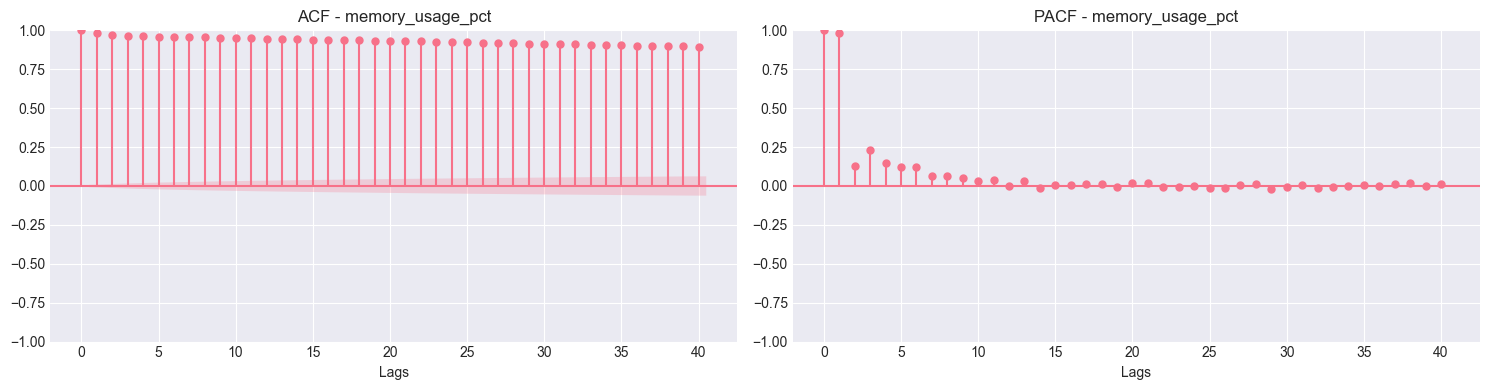

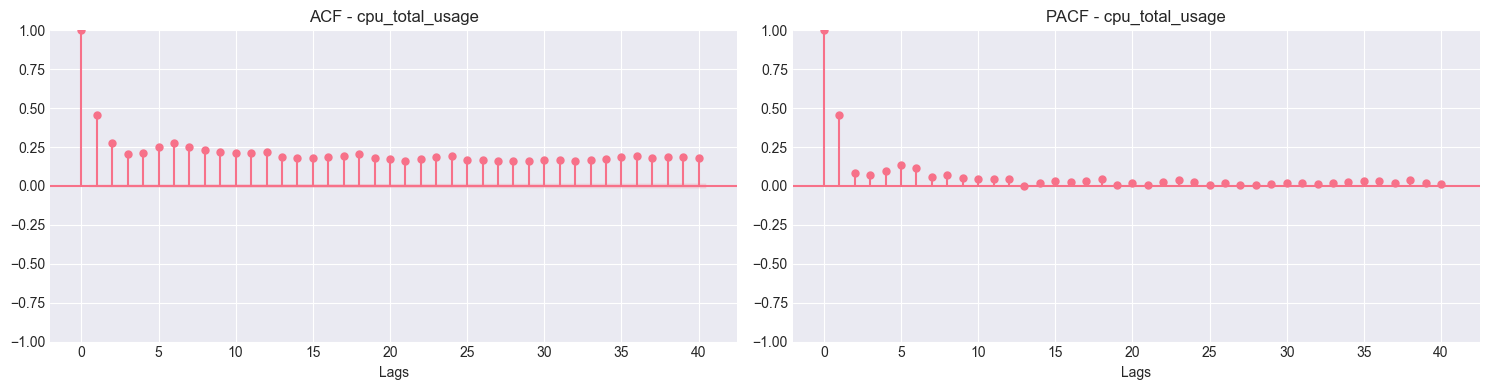

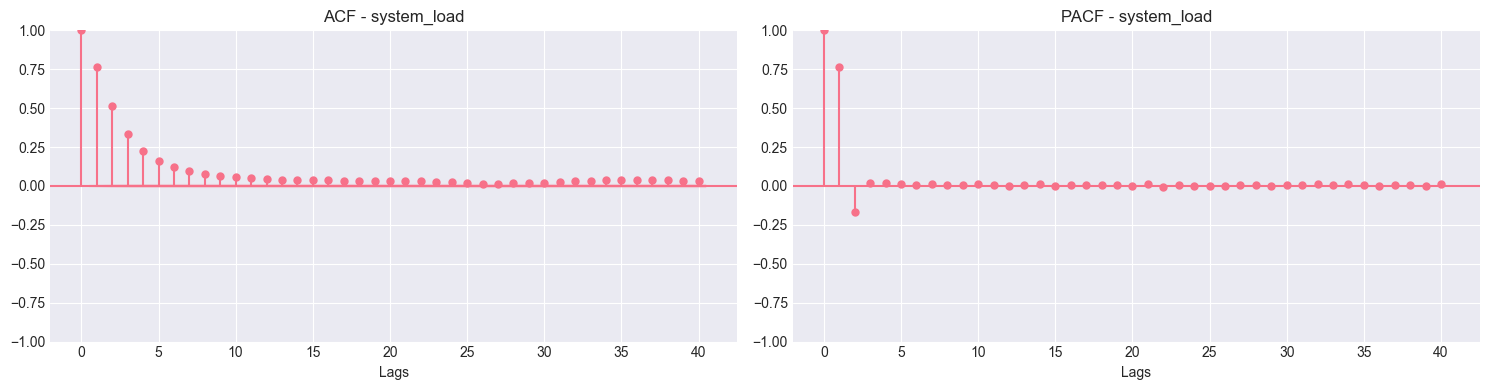

In [5]:
# Plot ACF and PACF for parameter selection
def plot_acf_pacf(series, target_name, lags=40):
    """Plot ACF and PACF to help determine p and q"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    
    # ACF - helps determine q (MA order)
    plot_acf(series.dropna(), lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title(f'ACF - {target_name}')
    axes[0].set_xlabel('Lags')
    
    # PACF - helps determine p (AR order)
    plot_pacf(series.dropna(), lags=lags, ax=axes[1], alpha=0.05)
    axes[1].set_title(f'PACF - {target_name}')
    axes[1].set_xlabel('Lags')
    
    plt.tight_layout()
    plt.show()

print("ACF/PACF Analysis:")
print("="*80)
for target in target_vars:
    y_train = datasets[target]['y_train']
    plot_acf_pacf(y_train, target)


## 4. ARIMAX Configuration

Based on stationarity tests and ACF/PACF plots, configure ARIMAX parameters for each target.


In [6]:
# ARIMAX parameters
# Adjust these based on ACF/PACF analysis and stationarity tests
arimax_configs = {
    'memory_usage_pct': {
        'order': (2, 0, 2),  # (p, d, q)
        'seasonal_order': (0, 0, 0, 0),
    },
    'cpu_total_usage': {
        'order': (2, 0, 2),
        'seasonal_order': (0, 0, 0, 0),
    },
    'system_load': {
        'order': (2, 0, 2),
        'seasonal_order': (0, 0, 0, 0),
    }
}

# Forecast horizon: 10 minutes = 20 steps (30 seconds each)
FORECAST_HORIZON = 20

print("ARIMAX Configuration:")
print("="*80)
for target, config in arimax_configs.items():
    print(f"\n{target}:")
    print(f"  Order (p,d,q): {config['order']}")
    print(f"  Seasonal: {config['seasonal_order']}")
    print(f"  Features: {len(datasets[target]['features'])}")

print(f"\nForecast Horizon: {FORECAST_HORIZON} steps (10 minutes)")
print("="*80)


ARIMAX Configuration:

memory_usage_pct:
  Order (p,d,q): (2, 0, 2)
  Seasonal: (0, 0, 0, 0)
  Features: 7

cpu_total_usage:
  Order (p,d,q): (2, 0, 2)
  Seasonal: (0, 0, 0, 0)
  Features: 7

system_load:
  Order (p,d,q): (2, 0, 2)
  Seasonal: (0, 0, 0, 0)
  Features: 2

Forecast Horizon: 20 steps (10 minutes)


## 5. Train ARIMAX Models


In [7]:
# Train ARIMAX models
arimax_models = {}
training_results = {}

print("="*80)
print("TRAINING ARIMAX MODELS")
print("="*80)

for target in target_vars:
    print(f"\n{'='*80}")
    print(f"Target: {target}")
    print(f"{'='*80}")
    
    y_train = datasets[target]['y_train']
    X_train = datasets[target]['X_train']
    
    order = arimax_configs[target]['order']
    seasonal_order = arimax_configs[target]['seasonal_order']
    
    print(f"Parameters: ARIMAX{order}")
    print(f"Exogenous features: {len(X_train.columns)}")
    print(f"Training samples: {len(y_train):,}")
    print("\nTraining...")
    
    start_time = time.time()
    
    try:
        model = SARIMAX(
            y_train,
            exog=X_train,
            order=order,
            seasonal_order=seasonal_order,
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        fitted_model = model.fit(disp=False, maxiter=200, method='lbfgs')
        
        training_time = time.time() - start_time
        
        arimax_models[target] = fitted_model
        
        training_results[target] = {
            'order': order,
            'n_features': len(X_train.columns),
            'n_samples': len(y_train),
            'training_time': training_time,
            'aic': fitted_model.aic,
            'bic': fitted_model.bic,
            'converged': fitted_model.mle_retvals['converged']
        }
        
        print(f"✓ Completed in {training_time:.2f}s")
        print(f"  AIC: {fitted_model.aic:.2f}")
        print(f"  BIC: {fitted_model.bic:.2f}")
        print(f"  Converged: {fitted_model.mle_retvals['converged']}")
        
        # Save model
        print("\nSaving model...")
        model_path = save_model(
            fitted_model,
            model_name='arimax',
            target=target,
            config={
                'order': order,
                'seasonal_order': seasonal_order,
                'n_features': len(X_train.columns),
                'features': list(X_train.columns)
            },
            models_dir='models'
        )
        training_results[target]['model_path'] = model_path
        
    except Exception as e:
        print(f"✗ Training failed: {str(e)}")
        training_results[target] = {'error': str(e), 'success': False}

print("\n" + "="*80)
print("✓ Training completed and models saved")
print("="*80)


TRAINING ARIMAX MODELS

Target: memory_usage_pct
Parameters: ARIMAX(2, 0, 2)
Exogenous features: 7
Training samples: 68,599

Training...
✓ Completed in 845.01s
  AIC: -134726.46
  BIC: -134616.82
  Converged: False

Saving model...
✓ Model saved: models\arimax_memory_usage_pct_20251111_154333.pkl

Target: cpu_total_usage
Parameters: ARIMAX(2, 0, 2)
Exogenous features: 7
Training samples: 68,599

Training...
✓ Completed in 297.69s
  AIC: 136475.97
  BIC: 136585.60
  Converged: True

Saving model...
✓ Model saved: models\arimax_cpu_total_usage_20251111_154831.pkl

Target: system_load
Parameters: ARIMAX(2, 0, 2)
Exogenous features: 2
Training samples: 68,599

Training...
✓ Completed in 110.44s
  AIC: 1649.51
  BIC: 1713.47
  Converged: True

Saving model...
✓ Model saved: models\arimax_system_load_20251111_155022.pkl

✓ Training completed and models saved


## 6. Multi-Step Forecasting (10 minutes ahead)


In [8]:
# Perform forecasting using utility function
print("="*80)
print(f"MULTI-STEP FORECASTING (Horizon: {FORECAST_HORIZON} steps = 10 minutes)")
print("="*80)

forecast_results = {}

for target in target_vars:
    if target not in arimax_models:
        print(f"\n✗ Skipping {target} - model not trained")
        continue
    
    print(f"\n{'='*80}")
    print(f"Target: {target}")
    print(f"{'='*80}")
    
    model = arimax_models[target]
    y_test = datasets[target]['y_test']
    X_test = datasets[target]['X_test']
    
    try:
        # Use utility function for forecasting
        results = forecast_with_horizon(
            model, 
            y_test, 
            X_test, 
            horizon=FORECAST_HORIZON,
            model_type='arimax'
        )
        
        forecast_results[target] = results
        
    except Exception as e:
        print(f"✗ Forecasting failed: {str(e)}")
        forecast_results[target] = {'error': str(e), 'success': False}

print("\n" + "="*80)
print("✓ Forecasting completed")
print("="*80)


MULTI-STEP FORECASTING (Horizon: 20 steps = 10 minutes)

Target: memory_usage_pct
Forecasting with horizon=20 steps (10.0 minutes)
  Forecasting 17131 points with horizon=20


    Progress: 1000/17131
    Progress: 2000/17131
    Progress: 3000/17131
    Progress: 4000/17131
    Progress: 5000/17131
    Progress: 6000/17131
    Progress: 7000/17131
    Progress: 8000/17131
    Progress: 9000/17131
    Progress: 10000/17131
    Progress: 11000/17131
    Progress: 12000/17131
    Progress: 13000/17131
    Progress: 14000/17131
    Progress: 15000/17131
    Progress: 16000/17131
    Progress: 17000/17131
✓ Completed in 178.34s
  Predictions: 17,131

Target: cpu_total_usage
Forecasting with horizon=20 steps (10.0 minutes)
  Forecasting 17131 points with horizon=20
    Progress: 1000/17131
    Progress: 2000/17131
    Progress: 3000/17131
    Progress: 4000/17131
    Progress: 5000/17131
    Progress: 6000/17131
    Progress: 7000/17131
    Progress: 8000/17131
    Progress: 9000/17131
    Progress: 10000/17131
    Progress: 11000/17131
    Progress: 12000/17131
    Progress: 13000/17131
    Progress: 14000/17131
    Progress: 15000/17131
    Progress: 16000/1713

In [9]:
# Calculate metrics using utility function
print("="*80)
print("EVALUATION METRICS")
print("="*80)

evaluation_results = {}

for target in target_vars:
    if target not in forecast_results or 'predictions' not in forecast_results[target]:
        print(f"\n✗ Skipping {target} - no predictions")
        continue
    
    print(f"\n{'='*80}")
    print(f"Target: {target}")
    print(f"{'='*80}")
    
    y_true = forecast_results[target]['actual']
    y_pred = forecast_results[target]['predictions']
    
    # Use utility function
    metrics = calculate_metrics(y_true, y_pred)
    evaluation_results[target] = metrics
    
    # Print metrics using utility function
    print_metrics(metrics, target)

print("\n" + "="*80)
print("✓ Evaluation completed")
print("="*80)


EVALUATION METRICS

Target: memory_usage_pct

Metrics for memory_usage_pct:
  MAE:         3.635920
  RMSE:        4.121623
  MAPE:        882.56%
  R²:          -20.680178
  Max Error:   7.000780
  Median AE:   3.747630

Target: cpu_total_usage

Metrics for cpu_total_usage:
  MAE:         0.301696
  RMSE:        0.795033
  MAPE:        105.18%
  R²:          0.339576
  Max Error:   20.588487
  Median AE:   0.151953

Target: system_load

Metrics for system_load:
  MAE:         1.471919
  RMSE:        1.834266
  MAPE:        2456.34%
  R²:          -2.506799
  Max Error:   11.497747
  Median AE:   1.430066

✓ Evaluation completed


## 8. Visualization


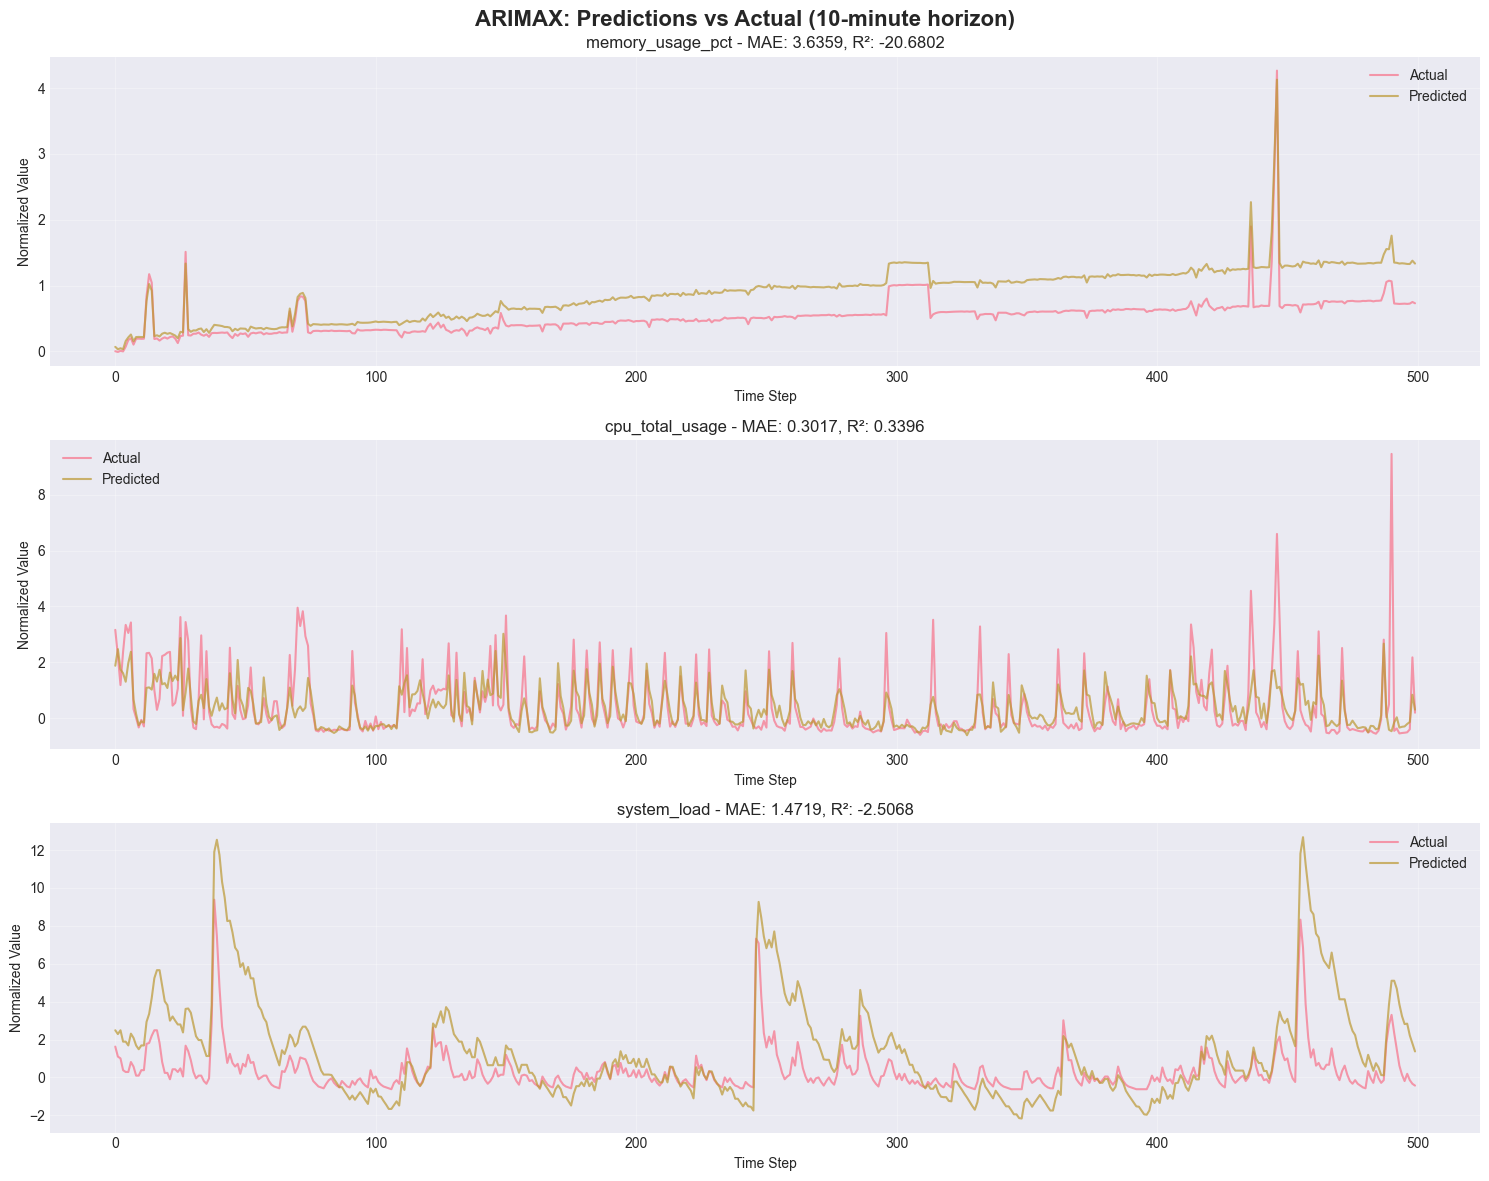

In [10]:
# Plot predictions vs actual
fig, axes = plt.subplots(3, 1, figsize=(15, 12))
fig.suptitle('ARIMAX: Predictions vs Actual (10-minute horizon)', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_vars):
    if target not in forecast_results or 'predictions' not in forecast_results[target]:
        continue
    
    y_true = forecast_results[target]['actual']
    y_pred = forecast_results[target]['predictions']
    
    # Plot first 500 points for clarity
    n_plot = min(500, len(y_true))
    
    axes[idx].plot(y_true[:n_plot], label='Actual', alpha=0.7, linewidth=1.5)
    axes[idx].plot(y_pred[:n_plot], label='Predicted', alpha=0.7, linewidth=1.5)
    axes[idx].set_title(f'{target} - MAE: {evaluation_results[target]["mae"]:.4f}, R²: {evaluation_results[target]["r2"]:.4f}')
    axes[idx].set_xlabel('Time Step')
    axes[idx].set_ylabel('Normalized Value')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


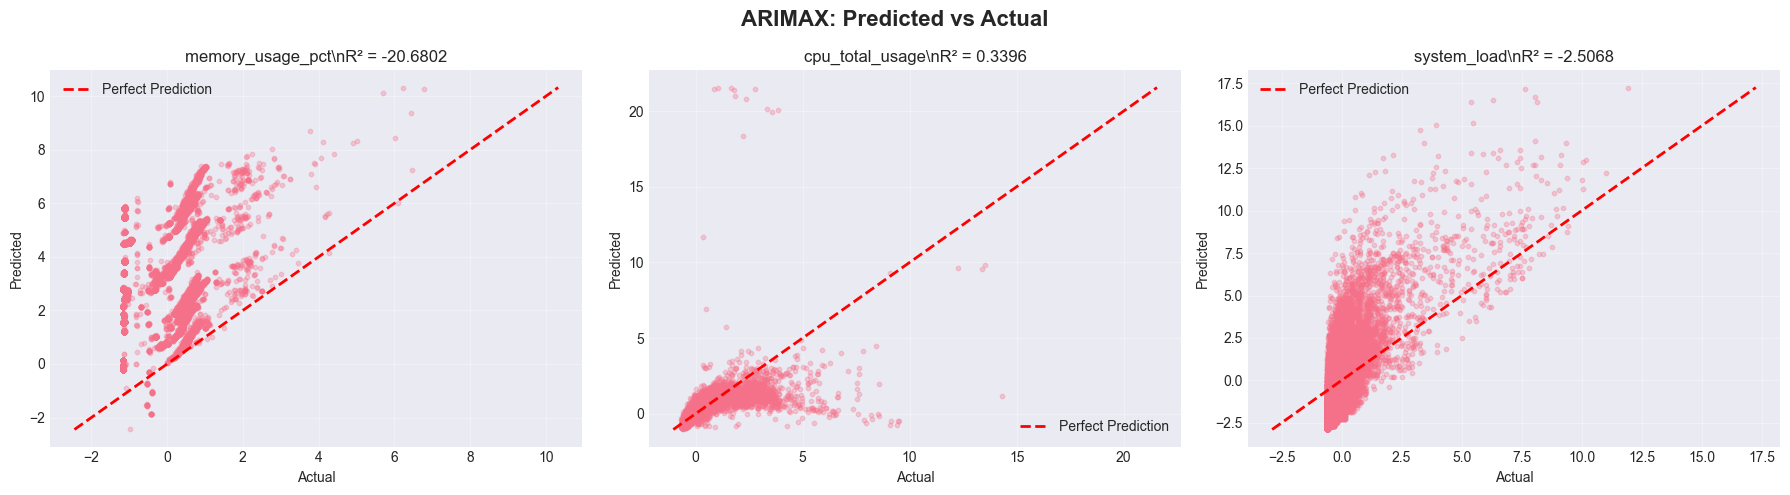

In [11]:
# Scatter plots: Predicted vs Actual
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ARIMAX: Predicted vs Actual', fontsize=16, fontweight='bold')

for idx, target in enumerate(target_vars):
    if target not in forecast_results or 'predictions' not in forecast_results[target]:
        continue
    
    y_true = forecast_results[target]['actual']
    y_pred = forecast_results[target]['predictions']
    
    axes[idx].scatter(y_true, y_pred, alpha=0.3, s=10)
    
    # Perfect prediction line
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    axes[idx].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
    
    axes[idx].set_title(f'{target}\\nR² = {evaluation_results[target]["r2"]:.4f}')
    axes[idx].set_xlabel('Actual')
    axes[idx].set_ylabel('Predicted')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


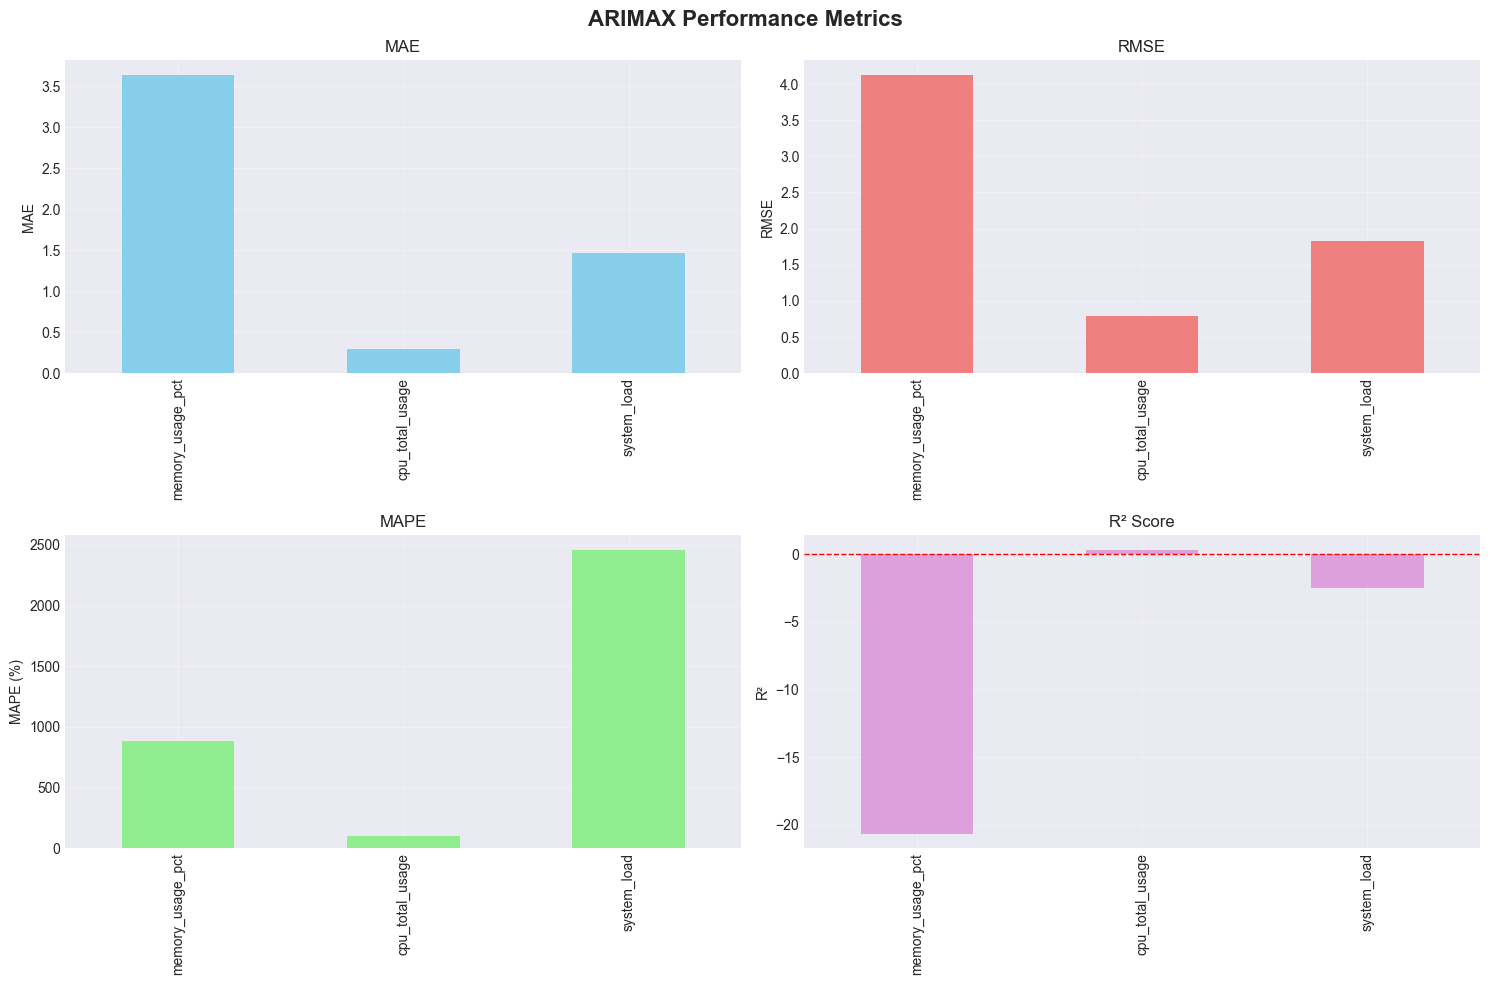

In [12]:
# Metrics comparison
metrics_df = pd.DataFrame(evaluation_results).T

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('ARIMAX Performance Metrics', fontsize=16, fontweight='bold')

metrics_df['mae'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('MAE')
axes[0, 0].set_ylabel('MAE')
axes[0, 0].grid(True, alpha=0.3)

metrics_df['rmse'].plot(kind='bar', ax=axes[0, 1], color='lightcoral')
axes[0, 1].set_title('RMSE')
axes[0, 1].set_ylabel('RMSE')
axes[0, 1].grid(True, alpha=0.3)

metrics_df['mape'].plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('MAPE')
axes[1, 0].set_ylabel('MAPE (%)')
axes[1, 0].grid(True, alpha=0.3)

metrics_df['r2'].plot(kind='bar', ax=axes[1, 1], color='plum')
axes[1, 1].set_title('R² Score')
axes[1, 1].set_ylabel('R²')
axes[1, 1].axhline(y=0, color='r', linestyle='--', linewidth=1)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 9. Save Results


In [13]:
# Compile results
final_results = {
    'model': 'ARIMAX',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'forecast_horizon': FORECAST_HORIZON,
    'forecast_horizon_minutes': FORECAST_HORIZON * 0.5,
    'targets': {}
}

for target in target_vars:
    if target not in evaluation_results:
        continue
    
    final_results['targets'][target] = {
        'model_config': {
            'order': arimax_configs[target]['order'],
            'seasonal_order': arimax_configs[target]['seasonal_order'],
            'n_features': training_results[target]['n_features']
        },
        'training': {
            'samples': training_results[target]['n_samples'],
            'time_seconds': training_results[target]['training_time'],
            'aic': training_results[target]['aic'],
            'bic': training_results[target]['bic'],
            'converged': training_results[target]['converged'],
            'model_path': training_results[target].get('model_path', '')
        },
        'forecasting': {
            'n_predictions': forecast_results[target]['n_predictions'],
            'time_seconds': forecast_results[target]['forecast_time']
        },
        'metrics': evaluation_results[target]
    }

# Save using utility function
output_file = save_results(final_results, 'results_arimax.json')

print("="*80)
print("RESULTS SUMMARY")
print("="*80)
print(f"Model: ARIMAX")
print(f"Forecast horizon: {FORECAST_HORIZON} steps ({FORECAST_HORIZON*0.5:.1f} min)")
print(f"Results saved to: {output_file}")
print(f"Models saved in: models/")
print("="*80)


✓ Results saved: results_arimax.json
RESULTS SUMMARY
Model: ARIMAX
Forecast horizon: 20 steps (10.0 min)
Results saved to: results_arimax.json
Models saved in: models/


## 10. Test with Different Horizons


In [14]:
# Test with multiple horizons
HORIZONS_TO_TEST = [20, 60]  # 5, 10, 20, 30 minutes

print("="*80)
print("TESTING MULTIPLE HORIZONS")
print("="*80)
print(f"Horizons: {HORIZONS_TO_TEST} steps")
print(f"Minutes: {[h*0.5 for h in HORIZONS_TO_TEST]}")
print()

horizon_comparison = {}

for target in target_vars:
    if target not in arimax_models:
        continue
    
    print(f"\n{'='*80}")
    print(f"Target: {target}")
    print(f"{'='*80}")
    
    model = arimax_models[target]
    y_test = datasets[target]['y_test']
    X_test = datasets[target]['X_test']
    
    horizon_comparison[target] = {}
    
    for horizon in HORIZONS_TO_TEST:
        print(f"  Testing horizon: {horizon} steps ({horizon*0.5:.1f} min)... ", end='')
        
        try:
            results = forecast_with_horizon(
                model, y_test, X_test,
                horizon=horizon,
                model_type='arimax'
            )
            
            metrics = calculate_metrics(results['actual'], results['predictions'])
            
            horizon_comparison[target][f"h{horizon}"] = {
                'horizon': horizon,
                'horizon_minutes': horizon * 0.5,
                'n_predictions': results['n_predictions'],
                'metrics': metrics
            }
            
            print(f"MAE={metrics['mae']:.4f}, R²={metrics['r2']:.4f}")
            
        except Exception as e:
            print(f"Failed: {str(e)}")

print("\n" + "="*80)
print("✓ Horizon testing completed")
print("="*80)


TESTING MULTIPLE HORIZONS
Horizons: [20, 60] steps
Minutes: [10.0, 30.0]


Target: memory_usage_pct
  Testing horizon: 20 steps (10.0 min)... Forecasting with horizon=20 steps (10.0 minutes)
  Forecasting 17131 points with horizon=20
    Progress: 1000/17131
    Progress: 2000/17131
    Progress: 3000/17131
    Progress: 4000/17131
    Progress: 5000/17131
    Progress: 6000/17131
    Progress: 7000/17131
    Progress: 8000/17131
    Progress: 9000/17131
    Progress: 10000/17131
    Progress: 11000/17131
    Progress: 12000/17131
    Progress: 13000/17131
    Progress: 14000/17131
    Progress: 15000/17131
    Progress: 16000/17131
    Progress: 17000/17131
✓ Completed in 155.46s
  Predictions: 17,131
MAE=3.6359, R²=-20.6802
  Testing horizon: 60 steps (30.0 min)... Forecasting with horizon=60 steps (30.0 minutes)
  Forecasting 17091 points with horizon=60
    Progress: 1000/17091
    Progress: 2000/17091
    Progress: 3000/17091
    Progress: 4000/17091
    Progress: 5000/17091
    P

In [15]:
# Comparison table
print("\nHORIZON COMPARISON:")
print("="*80)

for target in target_vars:
    if target not in horizon_comparison:
        continue
    
    print(f"\n{target.upper()}:")
    print(f"{'Horizon':>10} {'Minutes':>10} {'MAE':>12} {'RMSE':>12} {'R²':>12}")
    print("-" * 80)
    
    for h_key in sorted(horizon_comparison[target].keys(),
                       key=lambda x: horizon_comparison[target][x]['horizon']):
        h = horizon_comparison[target][h_key]
        print(f"{h['horizon']:>10} {h['horizon_minutes']:>10.1f} "
              f"{h['metrics']['mae']:>12.6f} {h['metrics']['rmse']:>12.6f} "
              f"{h['metrics']['r2']:>12.6f}")



HORIZON COMPARISON:

MEMORY_USAGE_PCT:
   Horizon    Minutes          MAE         RMSE           R²
--------------------------------------------------------------------------------
        20       10.0     3.635920     4.121623   -20.680178
        60       30.0     3.646118     4.128077   -20.738990

CPU_TOTAL_USAGE:
   Horizon    Minutes          MAE         RMSE           R²
--------------------------------------------------------------------------------
        20       10.0     0.301696     0.795033     0.339576
        60       30.0     0.300644     0.794623     0.335728

SYSTEM_LOAD:
   Horizon    Minutes          MAE         RMSE           R²
--------------------------------------------------------------------------------
        20       10.0     1.471919     1.834266    -2.506799
        60       30.0     1.383759     1.792520    -2.381730


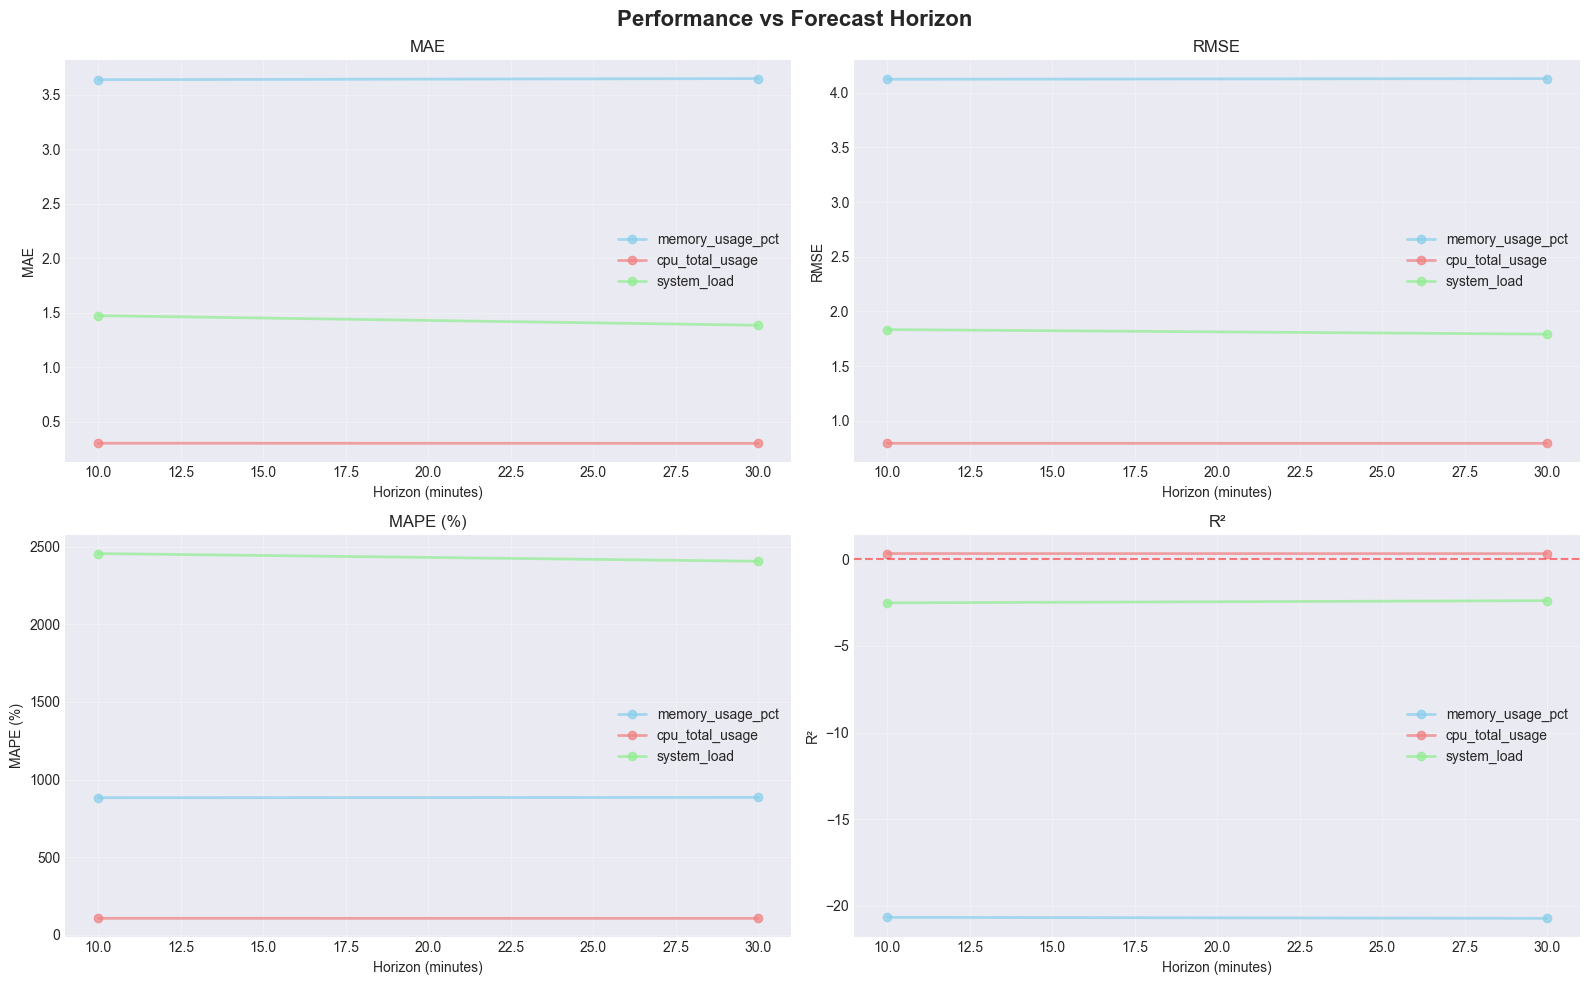

In [16]:
# Visualize performance vs horizon
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Performance vs Forecast Horizon', fontsize=16, fontweight='bold')

metrics_to_plot = ['mae', 'rmse', 'mape', 'r2']
titles = ['MAE', 'RMSE', 'MAPE (%)', 'R²']
colors_list = ['skyblue', 'lightcoral', 'lightgreen']

for idx, (metric, title) in enumerate(zip(metrics_to_plot, titles)):
    ax = axes[idx // 2, idx % 2]
    
    for cidx, target in enumerate(target_vars):
        if target not in horizon_comparison:
            continue
        
        horizons = []
        values = []
        
        for h_key in sorted(horizon_comparison[target].keys(),
                           key=lambda x: horizon_comparison[target][x]['horizon']):
            h = horizon_comparison[target][h_key]
            horizons.append(h['horizon_minutes'])
            values.append(h['metrics'][metric])
        
        ax.plot(horizons, values, marker='o', linewidth=2,
               label=target, alpha=0.7, color=colors_list[cidx])
    
    ax.set_title(title)
    ax.set_xlabel('Horizon (minutes)')
    ax.set_ylabel(title)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    if metric == 'r2':
        ax.axhline(y=0, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [17]:
# Save horizon comparison
horizon_results = {
    'model': 'ARIMAX',
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'horizons_tested': HORIZONS_TO_TEST,
    'targets': horizon_comparison
}

horizon_file = save_results(horizon_results, 'results_arimax_horizon_comparison.json')

print("\nBest horizon by MAE:")
for target in target_vars:
    if target in horizon_comparison:
        best = min(horizon_comparison[target].items(),
                  key=lambda x: x[1]['metrics']['mae'])
        print(f"  {target}: {best[1]['horizon']} steps - MAE: {best[1]['metrics']['mae']:.6f}")

print(f"\n✓ Horizon comparison saved to: {horizon_file}")


✓ Results saved: results_arimax_horizon_comparison.json

Best horizon by MAE:
  memory_usage_pct: 20 steps - MAE: 3.635920
  cpu_total_usage: 60 steps - MAE: 0.300644
  system_load: 60 steps - MAE: 1.383759

✓ Horizon comparison saved to: results_arimax_horizon_comparison.json
